# Parsing EXIOBASE 3.9

In [1]:
import pymrio as mr
import scipy as sp
import pandas as pd
import pickle

## Download the source files
Available at https://ntnu.app.box.com/s/gtxfosa7k7rj8stkp16rlj9pyp8nyem3/folder/193929480617

In [2]:
year = 2019
EXIOBASE_PATH = '../EXIOBASE/'

In [3]:
# Load the .mat data
io39mat           = sp.io.loadmat(EXIOBASE_PATH + 'EX_v3_9_mat/IOT_2019_ixi.mat')
emissions_fuel    = sp.io.loadmat(EXIOBASE_PATH + 'EX_v3_9_mat/EnergyEmis/Extensions_2019_ixi.mat')
emissions_nonfuel = sp.io.loadmat(EXIOBASE_PATH + 'EX_v3_9_mat/AirEmisNonFuel/Extensions_2019_ixi.mat')

In [4]:
io_vars = io39mat['IO'].dtype.names
io_vars

('S', 'A', 'Z', 'V', 'Y', 'x', 'FY', 'F', 'F_hh')

In [5]:
meta = io39mat['meta']

In [6]:
# For comparison with a 3.8.2 matrix
with open(f'EXIOBASE/IOT_{year}_ixi.pickle', 'rb') as handle:
    io38 = pickle.load(handle)

## Create the IO system by hand

First we declare the new IO system.

In [7]:
io39 = mr.IOSystem()

We need the labels to create the dataframes.

In [8]:
Z_index = pd.MultiIndex.from_tuples([(a[0],b[0]) for a,b in meta['labsZ'][0,0]])
Z_index.names = ['region', 'sector']

F_index = pd.MultiIndex.from_tuples([a[0] for a in meta['labsF'][0,0]])
F_index.names = ['stressor']

V_index = pd.MultiIndex.from_tuples([(a[0,0],b[0],c[0],d[0]) for a,b,c,d in meta['labsV'][0,0]])
V_index

Y_index = pd.MultiIndex.from_tuples([(a[0],b[0]) for a,b in meta['labsY'][0,0]])
Y_index.names = ['region', 'category']

### Core system
The following matrices are absolutely necessary for the full calculation: Z, Y, F.

This means that importing the rest of the data is optional.

Let us import Z and Y.

In [9]:
io39.Z = pd.DataFrame(data=io39mat['IO']['Z'][0,0].todense()*1e-6,
             index=Z_index,
             columns=Z_index)

io39.Y = pd.DataFrame(data=io39mat['IO']['Y'][0,0].todense()*1e-6,
                      index=Z_index,
                      columns=Y_index)

# Can be recalculated: x, A
# io39.x = pd.DataFrame(data=io39mat['IO']['A'][0,0].todense()*1e-6)

# io39.A = pd.DataFrame(data=io39mat['IO']['A'][0,0].todense()*1e-6,
#                       index=Z_index,
#                       columns=Z_index)


### Satellite accounts
In 3.9, the satellite accounts are organized in three separate blocks:
1. economic extensions,
2. emissions from energy use (fuel combustion),
3. emissions from non-energy use.

In [10]:
io39.satellite = mr.Extension('Satellite Accounts')

Let us import the various F matrices corresponding to these three categories.

In [11]:
F_econ    = io39mat['IO']['F'][0,0].todense()*1e-6
F_fuel    = emissions_fuel['Extensions']['F'][0,0]*1e-6
F_nonfuel = emissions_nonfuel['Extensions']['F'][0,0]*1e-6

FY_econ    = io39mat['IO']['F_hh'][0,0].todense()*1e-6 # This matrix has no meaning, but, if the matrices are consistently built, it exists as an array of zeros
FY_fuel    = emissions_fuel['Extensions']['FY'][0,0]*1e-6
FY_nonfuel = emissions_nonfuel['Extensions']['FY'][0,0]*1e-6

In [12]:
F_econ.shape, F_fuel.shape, F_nonfuel.shape

((9, 7987), (3507, 7987), (396, 7987))

In [13]:
FY_econ.shape, FY_fuel.shape, FY_nonfuel.shape

((9, 343), (3507, 343), (396, 343))

Get the labels

In [14]:
F_econ_index    = pd.Series([a[0][0] for a in meta['labsF'][0,0]], name='stressor')
F_fuel_index    = pd.Series([a[0][0] for a in emissions_fuel['meta_Extensions']['labsF'][0,0]], name='stressor')
F_nonfuel_index = pd.Series([a[0][0] for a in emissions_nonfuel['meta_Extensions']['labsF'][0,0]], name='stressor')

In [15]:
F_econ_index.shape, F_fuel_index.shape, F_nonfuel_index.shape

((9,), (3507,), (1707,))

There is an issue with the F_nonfuel labels, the length doesn't match that of the F_nonfuel matrix.

In [16]:
F_all  = sp.sparse.vstack([F_econ, F_fuel, F_nonfuel])
FY_all = sp.sparse.vstack([FY_econ, FY_fuel, FY_nonfuel])

### Characterization
Characterization factors are provided as text files (tab-separated values).

In [17]:
C_nonfuel = pd.read_csv(EXIOBASE_PATH + 'EX_v3_9_mat/AirEmisNonFuel/EXIOBASE_AirEmisNonFuel_CC500f.txt', encoding = 'ISO-8859-1', sep='\t', index_col=0)
C_fuel    = pd.read_csv(EXIOBASE_PATH + 'EX_v3_9_mat/EnergyEmis/EXIOBASE_EnergyEmis_CC14f.txt', encoding = 'ISO-8859-1', sep='\t', index_col=0)

There is a bit of cleaning to do...

In [18]:
C_fuel_columns    = C_fuel.columns.to_frame()[0].str.split('|', expand=True)
C_nonfuel_columns = C_nonfuel.columns.to_frame()[0].str.split('|', expand=True)

C_fuel_columns.columns = C_nonfuel_columns.columns = ['stressor', 'unit', 'comment', 'source']

C_fuel.columns    = pd.MultiIndex.from_frame(C_fuel_columns)
C_nonfuel.columns = pd.MultiIndex.from_frame(C_nonfuel_columns)

C_fuel.index.name = C_nonfuel.index.name = 'stressor'

C_econ is missing, we have to create it by hand.

In [19]:
C_fuel.columns[:3]

MultiIndex([(    'Value Added',   'M.EUR', '', ''),
            (     'Employment', '1000 p.', '', ''),
            ('Employment hour',      'hr', '', '')],
           names=['stressor', 'unit', 'comment', 'source'])

In [20]:
C_econ = pd.DataFrame(index=F_econ_index, columns=C_fuel.columns[:3]).fillna(0)
C_econ[(    'Value Added',   'M.EUR', '', '')] = 1
C_econ

C:\Users\Gibon\AppData\Local\Temp\ipykernel_9944\583420677.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  C_econ = pd.DataFrame(index=F_econ_index, columns=C_fuel.columns[:3]).fillna(0)


stressor,Value Added,Employment,Employment hour
unit,M.EUR,1000 p.,hr
comment,,,
source,,,
stressor,,,
Taxes less subsidies on products purchased: Total,1,0,0
Other net taxes on production,1,0,0
"Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",1,0,0
"Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",1,0,0
"Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",1,0,0
Operating surplus: Consumption of fixed capital,1,0,0


In [21]:
# C_fuel = C_fuel.fillna(0)

In [22]:
C_fuel[('GHG emissions AR5 (GWP100)', 'kg CO2 eq.', '', 'GWP100 (IPCC, 2010)')].nlargest()

stressor
N2O      265
CH4       28
CO2        1
As         0
B(a)P      0
Name: (GHG emissions AR5 (GWP100), kg CO2 eq., , GWP100 (IPCC, 2010)), dtype: int64

In [23]:
C_all = pd.concat([C_econ, C_fuel, C_nonfuel], axis=0).fillna(0)
C_all.shape

(3912, 499)

### Labelling extensions properly

In [24]:
F_all_index = pd.concat([F_econ_index,
                         F_fuel_index,
                         C_nonfuel.index.to_series()], axis=0)

In [25]:
io39.satellite.F = pd.DataFrame(data=F_all.todense(),
                      index=F_all_index,
                      columns=Z_index)

io39.satellite.FY = pd.DataFrame(data=FY_all.todense(),
                      index=F_all_index,
                      columns=Y_index)

In [26]:
io39.calc_all()

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:963: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_cba.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:972: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_pba.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:980: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_imp_reg = self.D_imp.groupby(
C:\Users\Gibon\.conda\env

In [27]:
comparison_x = pd.concat([io39.x,io38.x], axis=1, keys=['io39', 'io38'])

In [28]:
comparison_x

io39  \
                                                                 indout   
region sector                                                             
AT     Cultivation of paddy rice                               0.000000   
       Cultivation of wheat                                  339.520138   
       Cultivation of cereal grains nec                     1164.650232   
       Cultivation of vegetables, fruit, nuts               1829.872278   
       Cultivation of oil seeds                              243.015922   
...                                                                 ...   
WM     Activities of membership organisation n.e.c. (91)    8762.299672   
       Recreational, cultural and sporting activities ...  36368.596005   
       Other service activities (93)                       42144.210384   
       Private households with employed persons (95)       20060.994497   
       Extra-territorial organizations and bodies              0.000000   

                                                                   io38  
                                                                 indout  
region sector                                                            
AT     Cultivation of paddy rice                               0.000000  
       Cultivation of wheat                                  378.272102  
       Cultivation of cereal grains nec                      894.025172  
       Cultivation of vegetables, fruit, nuts               1665.261806  
       Cultivation of oil seeds                              175.855935  
...                                                                 ...  
WM     Activities of membership organisation n.e.c. (91)   22761.213885  
       Recreational, cultural and sporting activities ...  54138.374081  
       Other service activities (93)                       31620.402676  
       Private households with employed persons (95)        7096.152986  
       Extra-territorial organizations and bodies              0.000000  

[7987 rows x 2 columns]

In [29]:
io39.satellite.S.iloc[15]

region  sector                                             
AT      Cultivation of paddy rice                              0.000000
        Cultivation of wheat                                   0.279717
        Cultivation of cereal grains nec                       0.152510
        Cultivation of vegetables, fruit, nuts                 0.061252
        Cultivation of oil seeds                               0.107864
                                                                 ...   
WM      Activities of membership organisation n.e.c. (91)      0.085588
        Recreational, cultural and sporting activities (92)    0.042228
        Other service activities (93)                          0.156251
        Private households with employed persons (95)          0.182767
        Extra-territorial organizations and bodies             0.000000
Name: CO2, Length: 7987, dtype: float64

In [30]:
io38.satellite.S.iloc[23]

region  sector                                             
AT      Cultivation of paddy rice                                   0.000000
        Cultivation of wheat                                   631799.002656
        Cultivation of cereal grains nec                       261081.166377
        Cultivation of vegetables, fruit, nuts                  63322.120128
        Cultivation of oil seeds                               279931.683289
                                                                   ...      
WM      Activities of membership organisation n.e.c. (91)       12239.478385
        Recreational, cultural and sporting activities (92)      9705.666463
        Other service activities (93)                           12373.155200
        Private households with employed persons (95)            9972.086685
        Extra-territorial organizations and bodies                  0.000000
Name: CO2 - combustion - air, Length: 7987, dtype: float64

In [31]:
io39.satellite.S[io39.satellite.S.index.str.contains('CO2')]

region                                                                AT  \
sector                                         Cultivation of paddy rice   
stressor                                                                   
CO2                                                                  0.0   
CO2_bio                                                              0.0   
CO2 - non combustion - Cement production - air                       0.0   
CO2 - non combustion - Lime production - air                         0.0   
CO2 - agriculture - peat decay - air                                 0.0   
CO2 - waste - biogenic - air                                         0.0   
CO2 - waste - fossil - air                                           0.0   

region                                                               \
sector                                         Cultivation of wheat   
stressor                                                              
CO2                                                        0.279717   
CO2_bio                                                    0.048304   
CO2 - non combustion - Cement production - air             0.000000   
CO2 - non combustion - Lime production - air               0.000000   
CO2 - agriculture - peat decay - air                       0.066802   
CO2 - waste - biogenic - air                               0.000000   
CO2 - waste - fossil - air                                 0.000000   

region                                                                           \
sector                                         Cultivation of cereal grains nec   
stressor                                                                          
CO2                                                                    0.152510   
CO2_bio                                                                0.028091   
CO2 - non combustion - Cement production - air                         0.000000   
CO2 - non combustion - Lime production - air                           0.000000   
CO2 - agriculture - peat decay - air                                   0.030593   
CO2 - waste - biogenic - air                                           0.000000   
CO2 - waste - fossil - air                                             0.000000   

region                                                                                 \
sector                                         Cultivation of vegetables, fruit, nuts   
stressor                                                                                
CO2                                                                          0.061252   
CO2_bio                                                                      0.073414   
CO2 - non combustion - Cement production - air                               0.000000   
CO2 - non combustion - Lime production - air                                 0.000000   
CO2 - agriculture - peat decay - air                                         0.004950   
CO2 - waste - biogenic - air                                                 0.000000   
CO2 - waste - fossil - air                                                   0.000000   

region                                                                   \
sector                                         Cultivation of oil seeds   
stressor                                                                  
CO2                                                            0.107864   
CO2_bio                                                        0.020755   
CO2 - non combustion - Cement production - air                 0.000000   
CO2 - non combustion - Lime production - air                   0.000000   
CO2 - agriculture - peat decay - air                           0.046364   
CO2 - waste - biogenic - air                                   0.000000   
CO2 - waste - fossil - air                                     0.000000   

region                                                 

### Characterized impacts extension

In [32]:
io39.impacts = mr.Extension('impacts')

In [33]:
io39.impacts.F  = C_all.T.dot(io39.satellite.F)
io39.impacts.FY = C_all.T.dot(io39.satellite.FY)

In [34]:
io39.impacts.FY

region                                                                                                             AT  \
category                                                                  Final consumption expenditure by households   
stressor                                           unit    comment source                                               
Value Added                                        M.EUR                                                     0.000000   
Employment                                         1000 p.                                                   0.000000   
Employment hour                                    hr                                                        0.000000   
Total Emission relevant energy use                 TJ                                                        0.000000   
Carbon dioxide (CO2) IPCC categories 1 to 4 and... Gg                                                        0.018515   
...                                                                                                               ...   
currently blank                                    no_unit         .244                                      0.000000   
                                                                   .245                                      0.000000   
                                                                   .246                                      0.000000   
                                                                   .247                                      0.000000   
                                                                   .248                                      0.000000   

region                                                                                                                                                          \
category                                                                  Final consumption expenditure by non-profit organisations serving households (NPISH)   
stressor                                           unit    comment source                                                                                        
Value Added                                        M.EUR                                                                 0.0                                     
Employment                                         1000 p.                                                               0.0                                     
Employment hour                                    hr                                                                    0.0                                     
Total Emission relevant energy use                 TJ                                                                    0.0                                     
Carbon dioxide (CO2) IPCC categories 1 to 4 and... Gg                                                                    0.0                                     
...                                                                                                                      ...                                     
currently blank                                    no_unit         .244                                                  0.0                                     
                                                                   .245                                                  0.0                                     
                                                                   .246                                                  0.0                                     
                                                                   .247                                                  0.0                                     
                                                                   .248                                                  0.0                                     

region                              

In [35]:
io39.calc_all()

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:890: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:963: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_cba.groupby(level="region", axis=1, sort=False).sum()
C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pymrio\core\mriosystem.py:972: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_pba.groupby(level="region", axis=1, sort=False).sum()
C:

## Results

In [52]:
GHG39 = io39.impacts.D_cba_reg.loc[('GHG emissions AR5 (GWP100)', 'kg CO2 eq.', '', 'GWP100 (IPCC, 2010)')].sort_values()
GHG39

region
MT    6.422396e+03
CY    9.450328e+03
LV    1.570616e+04
EE    1.737270e+04
SI    2.171353e+04
LU    2.278982e+04
LT    2.649721e+04
HR    2.679116e+04
SK    4.658899e+04
BG    5.879439e+04
HU    7.540524e+04
PT    7.956531e+04
NO    8.288842e+04
DK    8.402005e+04
FI    8.457341e+04
GR    8.813153e+04
AT    1.035044e+05
SE    1.062530e+05
RO    1.105728e+05
CZ    1.270904e+05
BE    1.770337e+05
CH    1.801231e+05
ZA    1.859636e+05
IE    2.472702e+05
NL    2.620046e+05
PL    3.027319e+05
ES    3.571264e+05
WE    4.472480e+05
TR    4.564087e+05
AU    4.576126e+05
IT    4.965688e+05
CA    5.349844e+05
MX    5.662176e+05
FR    5.939281e+05
TW    6.302619e+05
GB    7.470241e+05
ID    9.144697e+05
BR    9.500267e+05
DE    1.006991e+06
KR    1.050013e+06
RU    1.310738e+06
WL    1.320370e+06
JP    1.703902e+06
WF    2.305544e+06
WM    2.497201e+06
IN    3.276958e+06
WA    5.268582e+06
US    6.199745e+06
CN    1.003807e+07
Name: (GHG emissions AR5 (GWP100), kg CO2 eq., , GWP100 (IPCC,

<Axes: ylabel='region'>

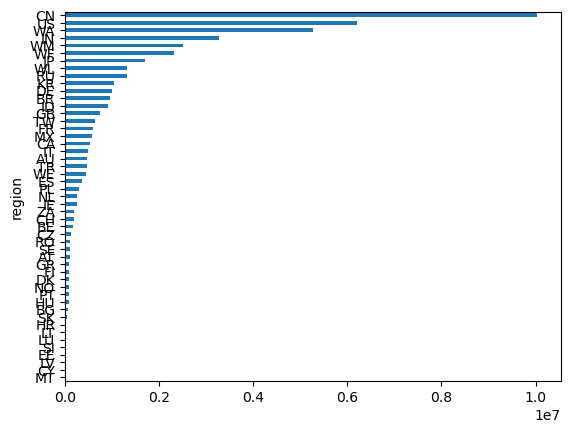

In [53]:
GHG39.plot.barh()

In [54]:
GHG38 = io38.impacts.D_cba_reg.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']*1e-6

<Axes: >

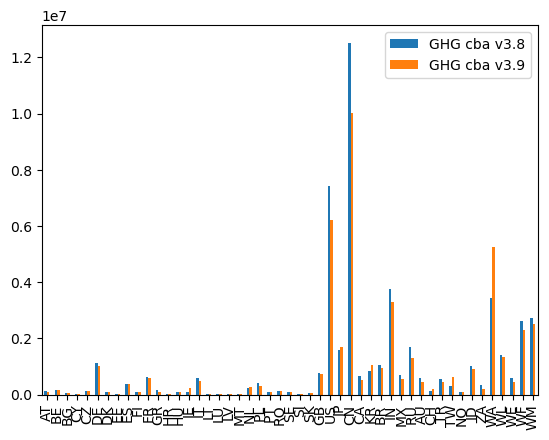

In [57]:
pd.concat([GHG38, GHG39], axis=1, keys=('GHG cba v3.8', 'GHG cba v3.9')).plot.bar()